In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

# Introduction to Random Forest
- It is a <b>non-parametric alogrithm</b>.
- A <b>parametric algorithm</b> makes strong assumptions to the problem and has a <b>fixed number of parameters</b> regardless of the size of data, which usaully simplfies the model to a fixed functional form. E.g. $\beta_1, \beta_2,..., \beta_n$ are the only parameters in linear regression model to tune.
- Examples of parametric ML models include linear regression, logistic regression, naive bayes, linear SVM, etc.
- A <b>non-parametric alogrithm</b>, on the other hand, makes weak assumptions on the form of model, and the number of parameters can grow with size of data, which makes the model more flexible and accurate, but it requires a large amount of data and logner time to train.
- Example of non-parametric ML models are kNN, random forest, kernalized SVM, deep neural network, etc.
- It is an <b>ensemble method</b>, that is, it aggregates the results from a group of simple estimators.
- The simple estimator used here is <b>decision tree</b>.

# Decision Tree
- Also refer as <b>CART (Classification and Regression Tree)</b>, always creates a binary tree (each non-terminal node has two child nodes).
- It accepts both <b>numerical and categorical</b> values.

## Intuition
- Akin to the process of human decision making, the algorithm follows the below steps:
    1. Asks a question about a feature of the data and split the group of data into two child nodes
    2. Recursively repeat step 1 on each child node until no more <b>information gain</b>
- So the problem is <b>what is the right question about the features to ask in every step</b>, and to find the <b>optimal cutoff value within a feature</b> to split each time.

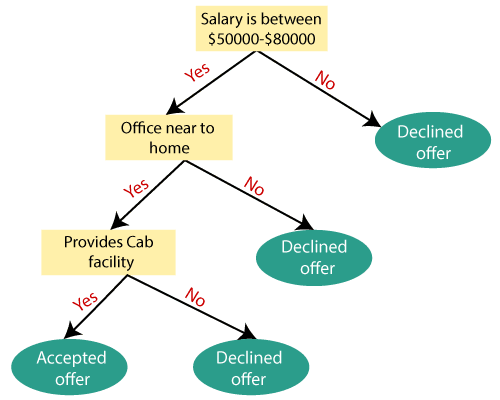

In [2]:
display.Image('img/3_descision_tree_eg.png', width=400)

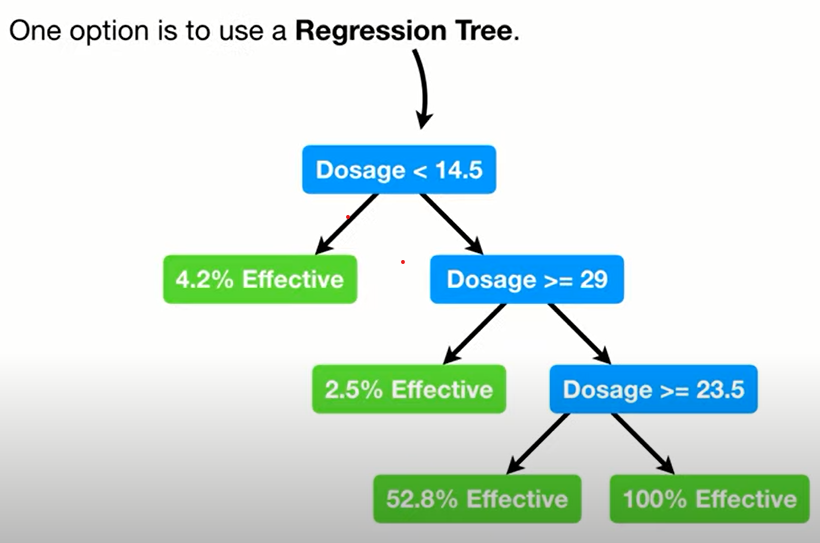

In [3]:
display.Image('img/3_regression_tree.png', width=500)

## Terminology

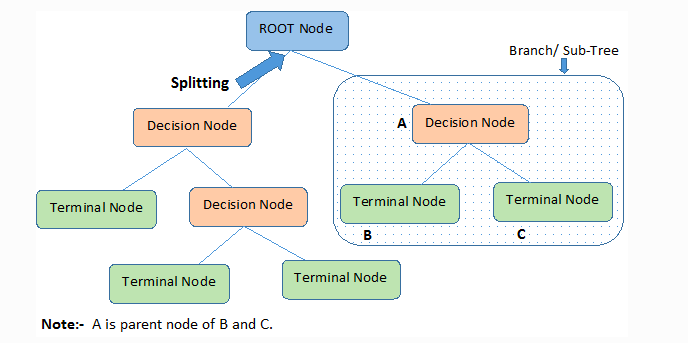

In [4]:
display.Image('img/3_tree_terminology.png')
# decision node or internal node
# terminal node or leaf node

- In classification, each terminal node/leaf represents a <b>class label</b>. 
- In regeression, each terminal node/leaf represents a <b>numeric value, which is the average of all target values in the node</b>.

## Mathematical Formulation
- We will discuss common methods to meausre the effectiveness of a split for both classification and regression with calculating examples.
- Classifcation: <b>information gain</b> and <b>Gini index</b>
- Regression: <b>reduction in variance</b>

### Shannon's Entropy and Information Gain
- It measures the disorder/impurity of a set, more precisely, it measures the uncertainty of a random variable (target variable in our case).
- It is a value <b>between 0 and 1</b>, 0 means everything is certain in the set (e.g. all elements belong to the same class), while 1 means the set is highly impure.
- Let $Y$ be a discrete random variable (target variable in our case), the entropy of $Y$ is <br>
$$H(Y) = \sum_{i=1}^{n}p(Y=y_i)log_2(\frac{1}{p(Y=y_i)}) =  -\sum_{i=1}^{n}p_ilog_2 p_i$$                    
- $H(Y)$ is the total amount of information contained by $Y$
- $\frac{1}{p(y)}$ is the <b>information contained when a case is known</b>. Why information contained in each case is the reciprocal of probability of that case is because if we are certain that a case with a small probability occurs, other cases contribute to a larger total probability won't occur, which in turn gives us more information about an event.
- The formula takes <b>log base 2</b> of information because it wants to calculate <b>how many bits</b> the information contains.

In [5]:
# function to calculate entropy of an array
from math import log2
from collections import Counter
def entropy(S):
    count = Counter(S)
    H = 0
    for k, v in count.items():
        px = v/len(S)
        H -= px*log2(px)
    return H

In [6]:
# test entropy
S = [0, 0, 0, 0]
print(entropy(S))
S = [0, 0, 1, 1]
print(entropy(S))
S = [0, 1, 1, 1]
print(entropy(S))
S = [0, 0, 0, 1]
print(entropy(S))

0.0
1.0
0.8112781244591328
0.8112781244591328


- Entropy is used to compute the <b>information gain of a split</b>. Let $S$ be the set/subset of data, $x_i$ be a feature column, the information gain of a split is given by:<br><br>
$$\text{Gain}(S, A) = H(S)-\sum_{v \in \text{Values}(x_{i})}\frac{|S_v|}{|S|}H(S_v)$$<br>
which is the difference between the entropy of the whole set and the weighted average of entropy of all splitted subset.
- The formula literally means that <b>how many impurity is removed after a split</b>.
- Decision tree will <b>choose a split with highest information gain</b> each time.

In [7]:
# sample data for calculating information gain
df = pd.DataFrame(data={
    'x1': [1, 1, 0, 1],
    'x2': [1, 1, 0, 0],
    'y': [0, 0, 1, 2]
})
df

,x1,x2,y
0,1,1,0
1,1,1,0
2,0,0,1
3,1,0,2


In [8]:
# function to calculate information gain of a dataset
def information_gain(df, feature_to_split, target):
    S = df[target]
    # entropy of unsplitted data
    gain = entropy(S)
    # list to store target values of splitted nodes
    S_vs = []
    # loop over each splitted node
    for v in df[feature_to_split].unique():
        # target values in a node
        S_v = df[df[feature_to_split] == v][target]
        # total minus weighted entropy of a node
        gain -= len(S_v)/len(S)*entropy(S_v)
        S_vs.append(S_v.tolist())
    return S_vs, gain

In [9]:
# split by x1
information_gain(df, 'x1', 'y')

([[0, 0, 2], [1]], 0.8112781244591328)

In [10]:
# split by x2
information_gain(df, 'x2', 'y')

([[0, 0], [1, 2]], 1.0)

It means that it's better to split by column x2 in the first split here. <br>

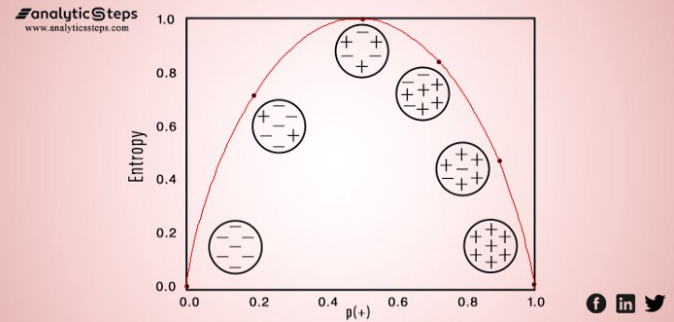

In [11]:
# how entropy of a node changes with number of classes in the node 
display.Image('img/3_entropy.png', width=500)

More explanation can be found at: https://towardsdatascience.com/the-intuition-behind-shannons-entropy-e74820fe9800

### Gini Impurity
- It measures the probability of a randomly chosen element would be incorrectly classified.
- It is a value between 0 and 0.5. 0 means only one class exists in the node. The lower the better.
- The Gini Index is given by<br>
$$G(X) = \sum_{i=1}^{n}p(X=x_i)(1-p(X=x_i)) = \sum_{i=1}^{n}p_i - \sum_{i=1}^{n} p_i^2 = 1-\sum_{i=1}^{n}p_i^2$$ where $n$ is the number of classes.

- The formula can be explained like this: let's say we have two classes {0, 1} in a set with ratio 0.3 and 0.7. Then we draw an element out of the set and guess which class it belongs to randomly according to the probability distribution {0.3, 0.7}. 
    1. We have 30% chance of guessing it is as 0, and for this 30% chance we have 70% chance of getting incorrect.
    2. We have 70% chance of guessing it is as 1, and for this 70% chance we have 30% chance of getting incorrect.
- So the total probability of the random guess to be incorrect is given by <br><br>$$0.3*(1-0.3)+0.7*(1-0.7)$$<br>
- Thus in general, the formula of Gini Impurity for $n$ classes is $\sum_{i=1}^{n}p_i(1-p_i)$
- The <b>total Gini Impurity of a split</b> is the weighted average of Gini Impurity of each child node.
- <b>The split with the lowest Gini Impurity is chosen.</b>

In [12]:
df

,x1,x2,y
0,1,1,0
1,1,1,0
2,0,0,1
3,1,0,2


In [13]:
# calculate gini of a node
def gini(S):
    count = Counter(S)
    G = 1
    for k, v in count.items():
        px = v/len(S)
        G -= px**2
    return G

In [14]:
# test gini
S = [0, 0, 0, 0]
print(gini(S))
S = [0, 0, 1, 1]
print(gini(S))
S = [0, 1, 1, 1]
print(gini(S))
S = [0, 0, 0, 1]
print(gini(S))

0.0
0.5
0.375
0.375


In [15]:
# function to calculate total Gini Impurity of splitted nodes
def total_gini(df, feature_to_split, target):
    # total Gini Impurity of nodes
    I = 0
    # list to store resultant split of target values
    S_vs = []    
    
    # loop over each splitted node
    for v in df[feature_to_split].unique():
        # target values in a node
        S_v = df[df[feature_to_split] == v][target]
        # Gini of a node 
        G = gini(S_v)
        # weight of the node
        weight = len(S_v)/len(df)
        # total Gini 
        I += G*weight
        S_vs.append(S_v.to_list())
    return S_vs, I

In [16]:
total_gini(df, 'x1', 'y')

([[0, 0, 2], [1]], 0.33333333333333337)

In [17]:
total_gini(df, 'x2', 'y')

([[0, 0], [1, 2]], 0.25)

It is better to split by column x2 first, which yields the same conclusion as information gain here.

### Comparison between Information Gain and Gini Impurity

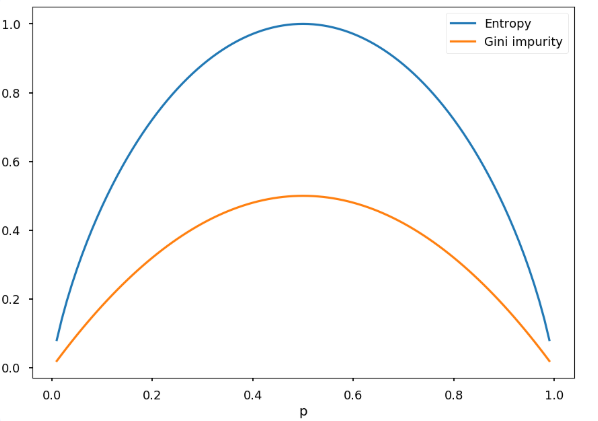

In [18]:
# how gini and entropy varies 
display.Image('img/3_gini_vs_entropy.png', width=500)

- In most cases information gain and Gini impurity give similar results, the difference lies on that for information gain needs to compute log but Gini impurity doesn't.
- More example at:
https://github.com/rasbt/python-machine-learning-book/blob/master/faq/decision-tree-binary.md

### Reduction in Variance
- It uses variance as a measure to decide which feature is used to split the node.
- Recall the variance of target values in a node is given by: <br> 
$$Var(S) = \frac{1}{n}\sum_{i=1}^{n}(y_i-\mu_{y})^2$$ <br>
- E.g. Node {1, 1, 1, 1, 1} has variacne 0 while node {1, 2, 3, 4, 5} has a variance of 2.5
- The total variance of a split is the weighted average of variances of all child nodes.
- <b>The split with the lowest total variance is chosen.</b>

## Visualizing Decision Boundaries

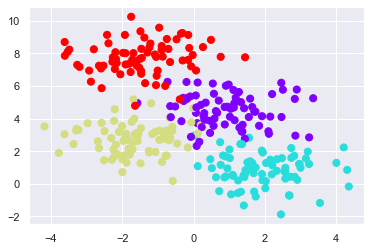

In [19]:
# generate data with 4 classes
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

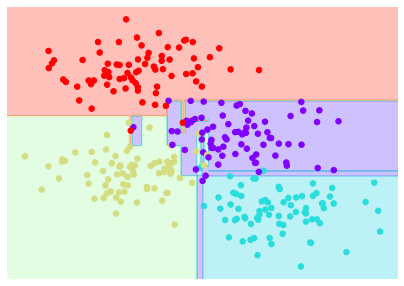

In [20]:
# visualize decision boundaries of decision tree model
from sklearn.tree import DecisionTreeClassifier
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    plt.figure(figsize=(7, 5))
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap, clim=(y.min(), y.max()), zorder=3)   # zorder=1, 2, 3, the higher the former
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200), np.linspace(*ylim, num=200))     # * to indicate passing arguments as tuple (start, end)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])    # np.c_ stack along the last axis
    Z = Z.reshape(xx.shape)    

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)    # plot filled contour
    ax.set(xlim=xlim, ylim=ylim)

visualize_classifier(DecisionTreeClassifier(), X, y);

In [21]:
# interactive visualization of decision tree model with different tree depths
from ipywidgets import interact, fixed
def interactive_tree(X, y, depth=5):
    clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
    visualize_classifier(clf, X, y)

interact(interactive_tree, X=fixed(X), y=fixed(y), depth=(1, 10));

interactive(children=(IntSlider(value=5, description='depth', max=10, min=1), Output()), _dom_classes=('widget…

When the depth increases, the decision regions become so fine which actually <b>overfit</b> the training data. This is a common problem in tree models, and ensemble method is used to make improvement.

# Random Forest with sklearn
- Random forest uses one of the ensemble methods named <b>bootstrap aggregating/bagging</b>, which take samples from training data with replacement (boostrap) for each model to train separately, followed by aggregating the results of all models to make the best prediction.
- The choice of feature in each split in base estimators is also <b>stochastiscally choosen from several features with top separating capabilities</b>.
- <b>Majority vote</b> of all base estimators determines the predicted class of a row of data.

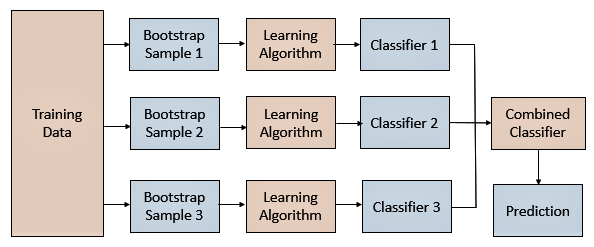

In [22]:
display.Image('img/3_boostrape_aggregation.png')

## Classification

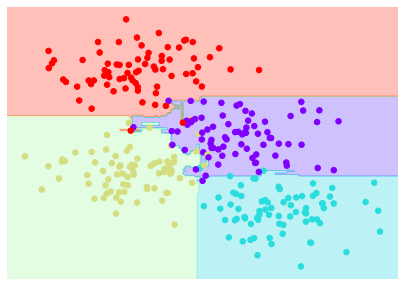

In [23]:
# decision tree + bagging
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=0)
# max_samples is the ratio of sample used to train each base estimator

bag.fit(X, y)
visualize_classifier(bag, X, y)

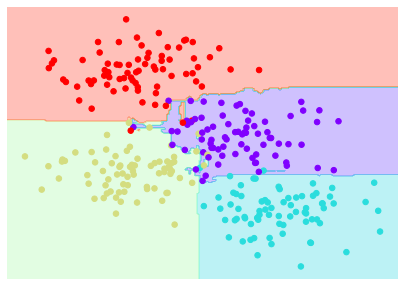

In [24]:
# random forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, max_samples=0.8, random_state=0)
visualize_classifier(model, X, y);

## Regression

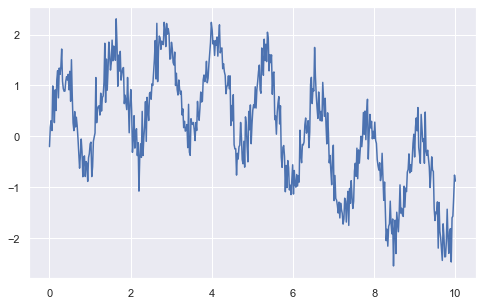

In [25]:
# generate a periodic time series
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)
x = np.linspace(0, 10, 500)

# model a curve of three components: fast and slow oscillation with random noise 
def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))
    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.figure(figsize=(8, 5))
plt.plot(x, y);

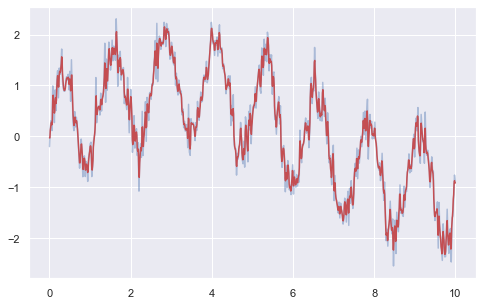

In [26]:
# random forest regressor can be trained to model the time series quite well
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])

plt.figure(figsize=(8, 5))
plt.plot(x, y, alpha=0.4);
plt.plot(xfit, yfit, '-r');

We can see that random forest can model the training data quite well for both classfication and regresson tasks. Let's do a more rigorous test below with untrained testing data.

# Practical: Recognizing Hand-written Digits with Random Forest Classifier

In [27]:
# load digits dataset from sklearn
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [28]:
# check target distribution
# data quite balance, not need to adjust class_weight of model
from collections import Counter
target = [digits.target_names[x] for x in digits.target]
df = pd.DataFrame(Counter(target).items(), columns=['target', 'freq'])
df

,target,freq
0,0,178
1,1,182
2,2,177
3,3,183
4,4,181
5,5,182
6,6,181
7,7,179
8,8,174
9,9,180


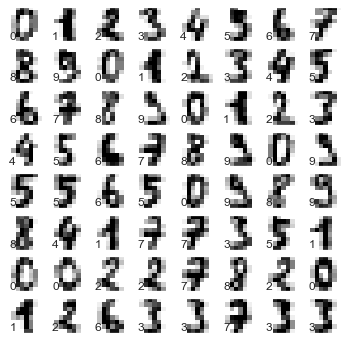

In [29]:
# visualize part of the dataset
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

In [30]:
# split data and fit model
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target, random_state=0) # default 25% test data
model = RandomForestClassifier(n_estimators=1000)    # default 100
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

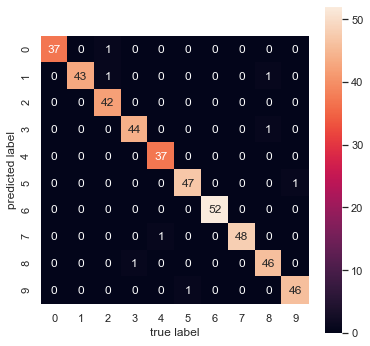

In [31]:
# confusion matrix of test result
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
plt.figure(figsize=(6, 6))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)
plt.xlabel('true label')
plt.ylabel('predicted label');

# Visualizing Tree Models
- One advantage of using tree model is that it is <b>highly interpretable</b>, we could visualize an estimator to understand the whole decision process.

## Decision Tree

In [32]:
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
# Prepare the data data
iris = datasets.load_iris()
X = iris.data
y = iris.target
# Fit the classifier with default hyper-parameters
clf = DecisionTreeClassifier(random_state=0)
model = clf.fit(X, y)

In [33]:
# view and save as text
text_representation = tree.export_text(clf, feature_names=iris.feature_names)
print(text_representation)
with open("decistion_tree.log", "w") as f:
    f.write(text_representation)

|--- petal width (cm) <= 0.80
|   |--- class: 0
|--- petal width (cm) >  0.80
|   |--- petal width (cm) <= 1.75
|   |   |--- petal length (cm) <= 4.95
|   |   |   |--- petal width (cm) <= 1.65
|   |   |   |   |--- class: 1
|   |   |   |--- petal width (cm) >  1.65
|   |   |   |   |--- class: 2
|   |   |--- petal length (cm) >  4.95
|   |   |   |--- petal width (cm) <= 1.55
|   |   |   |   |--- class: 2
|   |   |   |--- petal width (cm) >  1.55
|   |   |   |   |--- petal length (cm) <= 5.45
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- petal length (cm) >  5.45
|   |   |   |   |   |--- class: 2
|   |--- petal width (cm) >  1.75
|   |   |--- petal length (cm) <= 4.85
|   |   |   |--- sepal width (cm) <= 3.10
|   |   |   |   |--- class: 2
|   |   |   |--- sepal width (cm) >  3.10
|   |   |   |   |--- class: 1
|   |   |--- petal length (cm) >  4.85
|   |   |   |--- class: 2



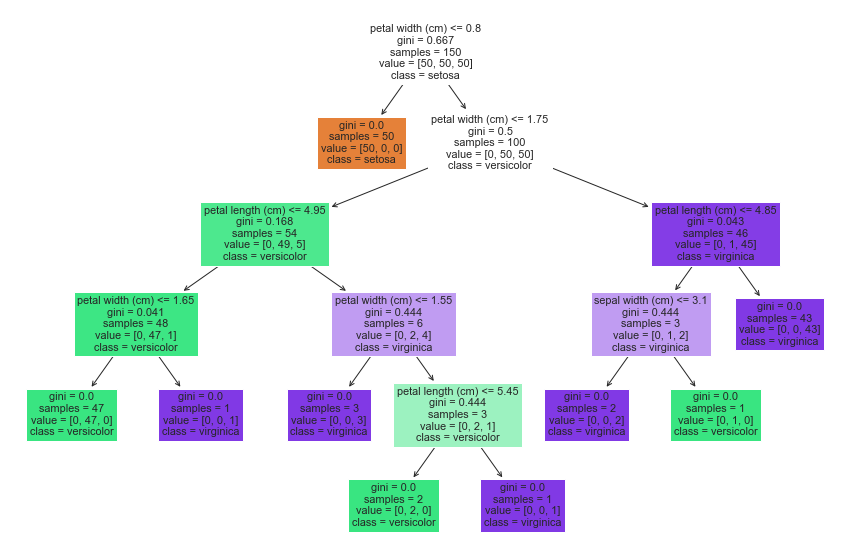

In [34]:
# draw a better-looking tree diagram
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(clf, feature_names=iris.feature_names, class_names=iris.target_names, filled=True)
fig.savefig("decistion_tree.png")

## Random Forest
- For random forest, one have to choose one of the estimators to plot.

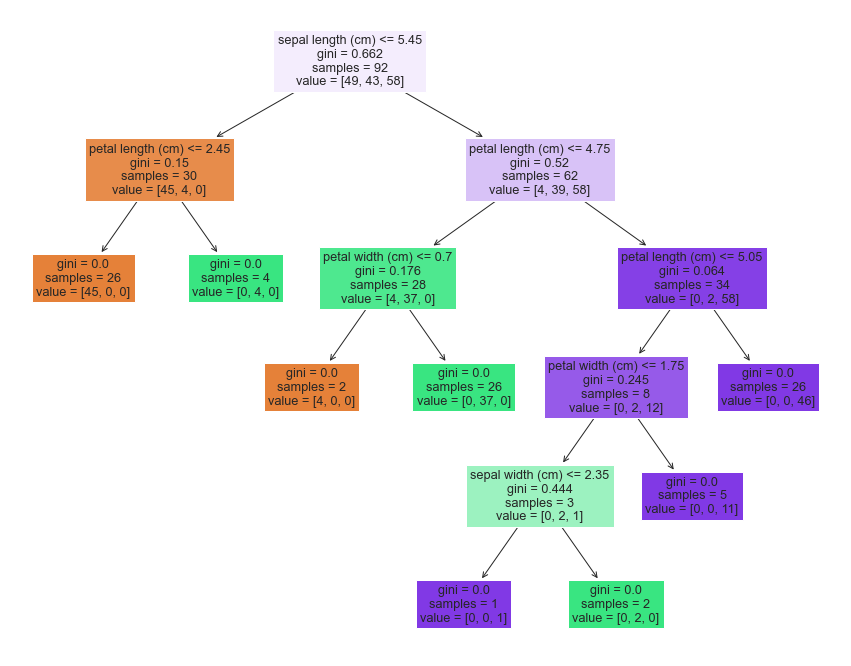

In [35]:
model = RandomForestClassifier()
model.fit(X, y)
estimator = model.estimators_[3]
fig = plt.figure(figsize=(15,12))
_ = tree.plot_tree(estimator, feature_names=iris.feature_names, filled=True)

You can plot both text and tree diagram for tree regressor.

# Problems may encounter with Random Forest

## Overfitting
- Tree based models do overfit, so tuning hyperparameters is important. In sklearn, some hyperparameters can be considered:

<ol> 
<li><b>n_estimators</b>: the number of base estimators use, the higher the number, the less likely overfitting occurs, although higher means a longer processing time</li>
<li><b>max_depth</b>: the maximum depth of the tree, the lower the number, the less likely overfitting occurs, although lower means a looser fit to training data which may in turn lower the prediciton power</li>
<li><b>min_samples_split</b>: the minimum number of samples required to split an internal node, the higher the number, the swallower the depth of the tree</li>
</ol>

## Poor performance for imbalanced data
- Note that both decision tree and bagging (and hence random forest) bias towards majority classes and thus <b>do not perform well for imbalanced datasets</b>. Techniques like <b>oversampling or undersampling</b> can be used before applying the models.